<a href="https://colab.research.google.com/github/Emilie-Jessen/AppML-Final-Project-2024/blob/main/EfficientNet_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
import tensorflow as tf
import tensorflow_hub as hub

In [2]:
from tensorflow.keras.applications import EfficientNetV2L, EfficientNetV2B3
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.image import grayscale_to_rgb
from tensorflow.keras.preprocessing.image import smart_resize
from tensorflow.keras.layers import Lambda, Dense, InputLayer, Rescaling, Dropout, Flatten
from tensorflow.keras import Sequential

In [3]:
print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.15.0
Hub version: 0.16.1
GPU is NOT AVAILABLE


In [4]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

SystemError: GPU device not found

In [ ]:
# The pictures are 48x48 pixels, but the model requires 128x128 pixels

input_pixels = 48
model_pixels = 128
IMAGE_SIZE = (input_pixels, input_pixels)
RE_SIZE = (model_pixels, model_pixels)
BATCH_SIZE = 16

In [ ]:
# Load the images from the test folder and create a dataset

def build_trainset(subset):
    return image_dataset_from_directory(
                        f"drive/MyDrive/archive/train",
                        label_mode="categorical",
                        color_mode="grayscale",
                        image_size=IMAGE_SIZE,
                        batch_size=1,
                        seed=42,
                        validation_split=0.2,
                        subset=subset)

In [ ]:
# Load the training and validation datasets
train_ds = build_trainset("training")
val_ds = build_trainset("validation")

# Get the names of the labels
class_names = tuple(train_ds.class_names)

# Print one image
for image, label in train_ds.take(1):
    plt.imshow(image[0], cmap='gray')
    plt.title(f"Label: {label[0]}")
    plt.show()

# Print the shape of the images
for image, label in train_ds.take(1):
    print(image.shape)

In [ ]:
print(class_names)

In [ ]:
# Preprocessing of the data

# The pictures are 48x48 pixels, but the model requires 128x128 pixels
resize_layer = Lambda(lambda x: smart_resize(x, size=RE_SIZE))

# The model requires 3 channels, so we need to convert the grayscale image to RGB
grayscale_to_rgb_layer = Lambda(lambda x: grayscale_to_rgb(x))

# Create preprocessing model
preprocessing_model = Sequential()
preprocessing_model.add(resize_layer)
preprocessing_model.add(grayscale_to_rgb_layer)

In [ ]:
# Apply the preprocessing model to the training and validation datasets
train_ds = train_ds.map(lambda image, label: (preprocessing_model(image), label))
val_ds = val_ds.map(lambda image, label: (preprocessing_model(image), label))

In [ ]:
# Print the same image after preprocessing
for image, label in train_ds.take(1):
    plt.imshow(image[0]*1/255)
    plt.title(f"Label: {label[0]}")
    plt.show()

# Print the shape of the images after preprocessing
for image, label in train_ds.take(1):
    print(image.shape)

In [ ]:
# Get class names and the size of the data sets
train_size = train_ds.cardinality().numpy()
val_size = val_ds.cardinality().numpy()

train_ds = train_ds.unbatch().batch(BATCH_SIZE)
val_ds = val_ds.unbatch().batch(BATCH_SIZE)

# Repeat training data set to ensure enough data
train_ds = train_ds.repeat()

In [ ]:
# Load the EfficientNetV2 model as the base model and freeze the weights
# Don't add top layer and add our own top

base_model = EfficientNetV2B3(input_shape=(model_pixels, model_pixels, 3),
                             include_top=False,
                             weights='imagenet',
                             pooling=None)

base_model.trainable = False

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 300

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False


# Add layers on top of the base model
model = Sequential([base_model,
                    Flatten(),
                    Dense(1024, activation='relu'),
                    Dropout(0.2),
                    Dense(256, activation='relu'),
                    Dropout(0.2),
                    Dense(len(class_names), kernel_regularizer=tf.keras.regularizers.l2(0.0001), activation='softmax')])

# Build the model
model.build((None,)+(model_pixels, model_pixels)+(3,))
model.summary()

In [ ]:
# Compile the model
base_learning_rate = 0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
steps_per_epoch = train_size // (BATCH_SIZE * 2)
validation_steps = val_size // BATCH_SIZE

print(steps_per_epoch)
print(train_size)

In [ ]:
# Train the model

# Implement early stopping with patience 3
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

# with tf.device('/device:GPU:0'):
hist = model.fit(train_ds,
                  batch_size=BATCH_SIZE,
                  epochs=10,
                  steps_per_epoch=steps_per_epoch,
                  validation_data=val_ds,
                  validation_steps=validation_steps,
                  callbacks=[early_stopping]).history

In [ ]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
#plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
#plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

In [ ]:
x, y = next(iter(val_ds))
image = x[0, :, :, :] * 1 / 255
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + class_names[true_index])
print("Predicted label: " + class_names[predicted_index])

In [ ]:
def build_testset():
    return image_dataset_from_directory(
                        f"drive/MyDrive/archive/test",
                        label_mode="categorical",
                        color_mode="grayscale",
                        image_size=IMAGE_SIZE,
                        batch_size=1,
                        seed=42)

In [ ]:
# Build test set
test_ds = build_testset()

# Apply the preprocessing model to the test dataset
test_ds = test_ds.map(lambda x, y: (preprocessing_model(x), y))

In [ ]:
# Build test set
test_ds = build_testset()

# Apply the preprocessing model to the test dataset
test_ds = test_ds.map(lambda x, y: (preprocessing_model(x), y))

# Get the test set size
test_size = test_ds.cardinality().numpy()

# Predict the labels of the test dataset
y_pred = model.predict(test_ds, verbose=1)

# Get the loss and accuracy of the model on the test dataset
loss, accuracy = model.evaluate(test_ds, verbose=1)

print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")

In [ ]:
# Get the true labels of the test dataset
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_true = np.argmax(y_true, axis=1)

# Get the predicted labels
y_pred = np.argmax(y_pred, axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
# Find out accuracy of each class

class_acc = np.zeros(len(cm))

for i in range(len(cm)):
  class_acc[i] = cm[i, i] / np.sum(cm[i, :])

print(class_acc)

In [ ]:
# Find out if this method works for saving the model

model.save("efficientnet_v2_finetuning.keras")

In [ ]:
for image, label in test_ds.take(1):
    predictions = model.predict(image)
    predicted_label = np.argmax(predictions, axis=1)
    plt.imshow(image[0]*1/255)
    plt.title(f"True label: {class_names[np.argmax(label[0])]}, Predicted label: {class_names[predicted_label[0]]}")
    plt.show()

Run with old weights

In [ ]:
# Load the model
old_model = tf.keras.models.load_model('drive/MyDrive/efficientnet_v2_incl_rescaling.keras')

# Show the model architecture
old_model.summary()

In [ ]:
# Predict the labels of the test dataset
y_pred = old_model.predict(test_ds, verbose=1)

# Get the loss and accuracy of the model on the test dataset
loss, accuracy = old_model.evaluate(test_ds, verbose=1)

print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")

In [ ]:
# Get the true labels of the test dataset
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_true = np.argmax(y_true, axis=1)

# Get the predicted labels
y_pred = np.argmax(y_pred, axis=1)

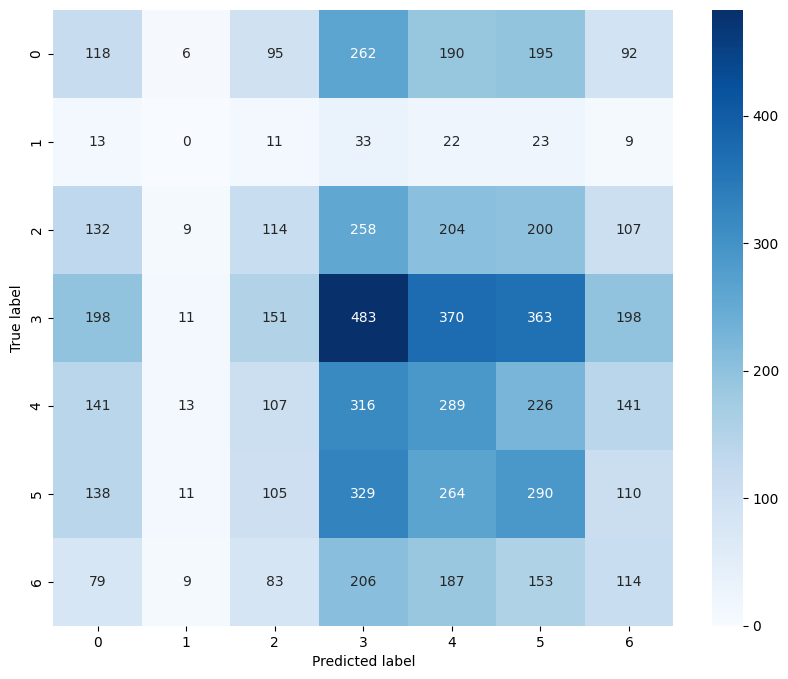

In [38]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [39]:
# Find out accuracy of each class

class_acc = np.zeros(len(cm))

for i in range(len(cm)):
  class_acc[i] = cm[i, i] / np.sum(cm[i, :])

print(class_acc)

[0.12317328 0.         0.11132812 0.27226607 0.23438767 0.23255814
 0.13718412]
